# Gaussian Mixture Modules vs K-Means


---

References: 

[**| &nbsp; Kacper Kubara** &nbsp; | &nbsp; Gaussian Mixture Models vs K-Means. Which One to Choose?](https://towardsdatascience.com/gaussian-mixture-models-vs-k-means-which-one-to-choose-62f2736025f0)

## K-Means and Gaussian Mixtures (GMs) 

...are both clustering models. Many data scientist, however, tend to choose a more popular K-Means algorithm. Even if GMs can prove superior in certain clustering problems.

In this article, we will see that both models offer a different performance in terms of speed and robustness. We will also see that it is possible to use K-Means as an initializer for GMs which tends to boost the performance of the clustering model.

How They Work

First, let’s review the theoretical part of these algorithms. It will help us to understand their behaviour later in the article.

In [1]:
import sklearn
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy.random import multivariate_normal
from numpy.random import uniform


In [2]:
# func to create data 

def create_dataset(n_samples=3000):
  """ Create dataset with 2 Gaussian distributions and uniform distribution"""
  n_sample = n_samples//3
  data = np.zeros([n_samples, 3])

  data_0 = multivariate_normal(mean=[-1, 1], cov=[[2, 1],[1, 2]], size=(n_sample))
  data_1 = multivariate_normal(mean=[1, 5], cov=[[3, 1],[2, 1]], size=(n_sample))
  data_2 = uniform([5, -3], [10, 5], size=(n_sample, 2))

  # Merged all datapoints into one dataset
  data[:n_sample, :2] = data_0
  data[:n_sample, 2] = np.asarray([0]*n_sample)
  data[n_sample:2*n_sample, :2] = data_1
  data[n_sample:2*n_sample, 2] = np.asarray([1]*n_sample)
  data[2*n_sample:, :2] = data_2
  data[2*n_sample:, 2] = np.asarray([2]*n_sample)

  return data


In [3]:
data = create_dataset()
print(type(data))

<class 'numpy.ndarray'>


<ipython-input-2-bb5e08b7a9ab>:9: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = multivariate_normal(mean=[1, 5], cov=[[3, 1],[2, 1]], size=(n_sample))


In [4]:
# func to plot data 

def plot_dataset(data):
  """ Plots the generated dataset"""
  data_0 = data[data[:, 2] == 0][:, :2]
  data_1 = data[data[:, 2] == 1][:, :2]
  data_2 = data[data[:, 2] == 2][:, :2]

  plt.scatter(data_0[:, 0], data_0[:, 1], c='r', label="Cluster 1")
  plt.scatter(data_1[:, 0], data_1[:, 1], c='b', label="Cluster 2")
  plt.scatter(data_2[:, 0], data_2[:, 1], c='g', label="Cluster 3")
  plt.legend()
  plt.title("2 ovelapping Gaussian distributions and one uniform distribution")
  plt.show()
  plt.clf()


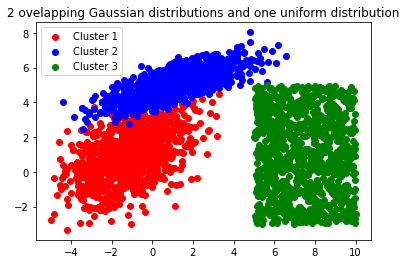

<Figure size 432x288 with 0 Axes>

In [5]:
plot_dataset(data)

## Cluster Shapes

Let’s get our hands dirty and do the initial clustering with K-Means and Gaussian Mixtures. We will use the models imported from Scikit-Learn. Additionally, we will set parameters in the same way for both models. Max no. iterations, number of clusters, and convergence tolerance are set the same for both models.

## How They Work

First, let’s review the theoretical part of these algorithms. It will help us to understand their behaviour later in the article.

### K-Means

K-Means is a popular non-probabilistic clustering algorithm. The goal of the algorithm is to minimize the distortion measure J. We achieve that by the following iterative procedure [1]:

1. Choose the number of clusters 
2. Initialize the vector μ_k that defines a central point of each cluster
3. Assign each data point x to the closest cluster centre
4. Recalculate central points μ_k for each cluster
5. Repeat 3–4 until central points stop moving

The K-Means algorithm will converge but it might not be a global minimum. To avoid a situation where it converges to a local minimum, K-Means should be re-run a few times with different parameters.

K-Means performs hard assignment which means that each datapoint has to belong to a certain class and there is no probability assigned to each datapoint.

The computational cost of the K-Means is O(KN), where K is a number of clusters and N is a number of datapoints.

### Gaussian Mixtures

Gaussian Mixtures are based on K independent Gaussian distributions that are used to model K separate clusters. As a reminder, the multivariate Gaussian distribution is given as:

https://miro.medium.com/max/3600/1*QAkYq08Dcw3p5WBvbn9mlQ.png

The derivation of the Gaussian mixtures is rather complicated, so for an in-depth mathematical explanation, I suggest looking at this article.

The most important thing to know about GMs is that the convergence of this model is based on the EM (expectation-maximization) algorithm. It is somewhat similar to K-Means and it can be summarized as follows [1]:

1. Initialize μ, ∑, and mixing coefficient π and evaluate the initial value of the log likelihood L
2. Evaluate the responsibility function using current parameters
3. Obtain new μ, ∑, and π using newly obtained responsibilities
4. Compute the log likelihood L again. Repeat steps 2–3 until the convergence.

The Gaussian Mixtures will also converge to a local minimum.

We can easily visualize how the convergence works for the Gaussian mixtures with the GIF below:

The first visible difference between K-Means and Gaussian Mixtures is the shape the decision boundaries. GMs are somewhat more flexible and with a covariance matrix ∑ we can make the boundaries elliptical, as opposed to circular boundaries with K-means.

Another thing is that GMs is a probabilistic algorithm. By assigning the probabilities to datapoints, we can express how strong is our belief that a given datapoint belongs to a specific cluster.

If we compare both algorithms, the Gaussian mixtures seem to be more robust. However, GMs usually tend to be slower than K-Means because it takes more iterations of the EM algorithm to reach the convergence. They can also quickly converge to a local minimum that is not a very optimal solution.

In the remainder of the article, we will look at how these models perform in practice using Scikit-learn library.


## Comparing the Performance

We will start by creating a synthetic dataset for this task. To make it more challenging, we will create 2 overlapping Gaussian distributions and add a uniform distribution on the side.

In [6]:
import sklearn
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy.random import multivariate_normal
from numpy.random import uniform


In [7]:
def create_dataset(n_samples=3000):
  """ Create dataset with 2 Gaussian distributions and uniform distribution"""
  n_sample = n_samples//3
  data = np.zeros([n_samples, 3])

  data_0 = multivariate_normal(mean=[-1, 1], cov=[[2, 1],[1, 2]], size=(n_sample))
  data_1 = multivariate_normal(mean=[1, 5], cov=[[3, 1],[2, 1]], size=(n_sample))
  data_2 = uniform([5, -3], [10, 5], size=(n_sample, 2))

  # Merged all datapoints into one dataset
  data[:n_sample, :2] = data_0
  data[:n_sample, 2] = np.asarray([0]*n_sample)
  data[n_sample:2*n_sample, :2] = data_1
  data[n_sample:2*n_sample, 2] = np.asarray([1]*n_sample)
  data[2*n_sample:, :2] = data_2
  data[2*n_sample:, 2] = np.asarray([2]*n_sample)

  return data


def plot_dataset(data):
  """ Plots the generated dataset"""
  data_0 = data[data[:, 2] == 0][:, :2]
  data_1 = data[data[:, 2] == 1][:, :2]
  data_2 = data[data[:, 2] == 2][:, :2]

  plt.scatter(data_0[:, 0], data_0[:, 1], c='r', label="Cluster 1")
  plt.scatter(data_1[:, 0], data_1[:, 1], c='b', label="Cluster 2")
  plt.scatter(data_2[:, 0], data_2[:, 1], c='g', label="Cluster 3")
  plt.legend()
  plt.title("2 ovelapping Gaussian distributions and one uniform distribution")
  plt.show()
  plt.clf()


<ipython-input-7-c4767199dd26>:7: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = multivariate_normal(mean=[1, 5], cov=[[3, 1],[2, 1]], size=(n_sample))


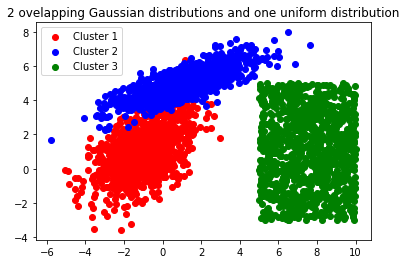

<Figure size 432x288 with 0 Axes>

In [8]:
data = create_dataset()
plot_dataset(data)


## Cluster Shapes

Let’s get our hands dirty and do the initial clustering with K-Means and Gaussian Mixtures. We will use the models imported from Scikit-Learn. Additionally, we will set parameters in the same way for both models. Max no. iterations, number of clusters, and convergence tolerance are set the same for both models.

In [9]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# init kmeans and gmm 
kmeans = KMeans(
    n_clusters = 3,
    max_iter   = 1000,
    tol        = 1e-4,
)

gm = GaussianMixture(
    n_components = 3,
    max_iter     = 1000,
    tol          = 1e-4,
    init_params  = 'random',
)

# fit and predict 
y_kmeans = kmeans.fit_predict(data[:, :2])
y_gm = gm.fit_predict(data[:, :2])
y_gm_proba = gm.predict_proba(data[:, :2])


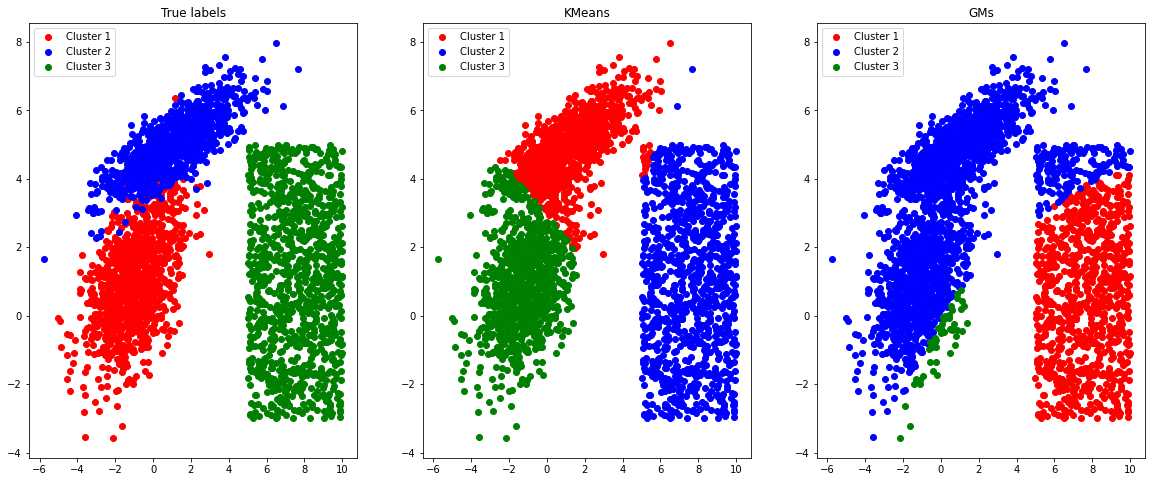

In [10]:
def plot_results(data, y_kmeans, y_gm):
  """Plot the results in one figure"""
  fig, ax = plt.subplots(1, 3)
  fig.set_size_inches(20, 8, forward=True)  
  labels = [data[:, 2], y_kmeans, y_gm]
  title = ["True labels", "KMeans", "GMs"]

  for i in range(len(labels)):
    data_0 = data[labels[i] == 0][:, :2]
    data_1 = data[labels[i] == 1][:, :2]
    data_2 = data[labels[i] == 2][:, :2]
    ax[i].scatter(data_0[:, 0], data_0[:, 1], c='r', label="Cluster 1")
    ax[i].scatter(data_1[:, 0], data_1[:, 1], c='b', label="Cluster 2")
    ax[i].scatter(data_2[:, 0], data_2[:, 1], c='g', label="Cluster 3")
    ax[i].set_title(title[i])
    ax[i].legend()
  
  plt.show()

plot_results(data, y_kmeans, y_gm)


From the first glance on the clustered data, we can see that they don’t perform very well. While K-Means clusters data in a similar fashion as from the true clusters, the GM clusters look pretty unreliable.

## K-Means + Gaussian Mixtures = ❤️

The problem with GMs is that they have converged quickly to a local minimum that is not very optimal for this dataset. To avoid this issue, GMs are usually initialized with K-Means. This usually works quite well and it improves clusters generated with K-Means. We can create GM with K-Means initializer by changing one parameter in the GaussianMixture class:

We can also leverage the probabilistic nature of GMs. By adding a threshold value, 0.33 in this case, we are able to flag labelled datapoints that model is unsure about. It gets quite interesting here because, for vanilla GM, most of the datapoints have low probabilities as seen in the middle plot below.

In [11]:
def plot_different_gms(data, threshold, 
                       y_gm, y_gm_proba, 
                       y_gm_kmeans, y_gm_proba_kmeans):
  """ Plots GMs with a random and kmeans initializer"""
  fig, ax = plt.subplots(1, 3)
  fig.set_size_inches(20, 8, forward=True)

  # Create new label ("unknown") for predictions < probability threshold
  y_gm_proba = np.amax(y_gm_proba, axis=1)
  y_gm[y_gm_proba < threshold] = 3
  
  y_gm_proba_kmeans = np.amax(y_gm_proba_kmeans, axis=1)
  y_gm_kmeans[y_gm_proba_kmeans < threshold] = 3

  labels = [data[:, 2], y_gm, y_gm_kmeans]
  title = ["True labels", 
           "GMs with random initializer", 
           "GMs with KMeans as initialization"]
  
  for i in range(len(labels)):
    data_0 = data[labels[i] == 0][:, :2]
    data_1 = data[labels[i] == 1][:, :2]
    data_2 = data[labels[i] == 2][:, :2]
    ax[i].scatter(data_0[:, 0], data_0[:, 1], c='r', label="Cluster 1")
    ax[i].scatter(data_1[:, 0], data_1[:, 1], c='b', label="Cluster 2")
    ax[i].scatter(data_2[:, 0], data_2[:, 1], c='g', label="Cluster 3")
    
    if i != 0:
      # First data are just true labels for comparison
      data_3 = data[labels[i] == 3][:, :2]
      ax[i].scatter(
          data_3[:, 0], 
          data_3[:, 1], 
          c='black', 
          label="Unknown Cluster")
    
    ax[i].set_title(title[i])
    ax[i].legend()

  plt.show()


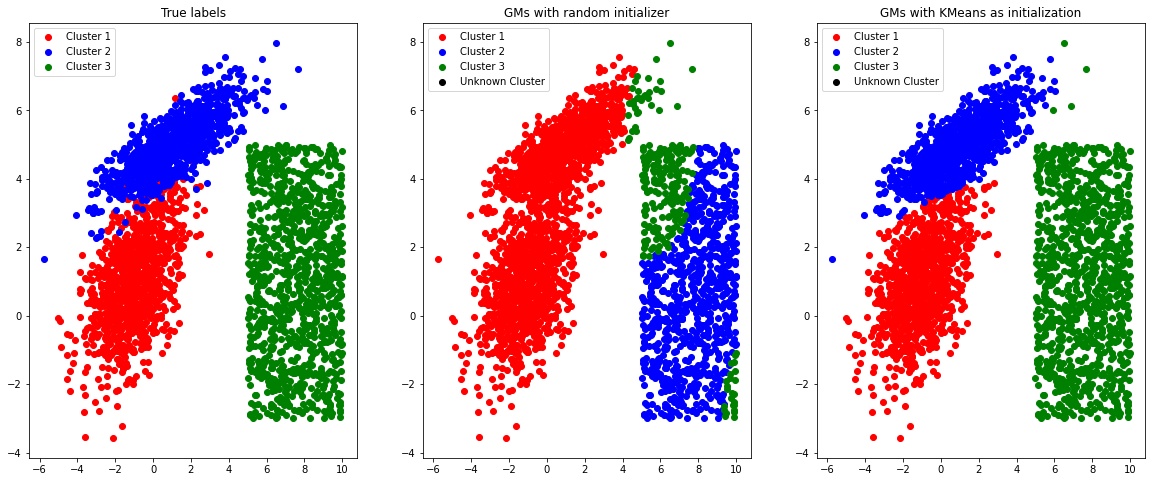

In [12]:
gm = GaussianMixture(
    n_components = 3,
    max_iter = 1000, 
    tol          = 1e-4,
    init_params  = 'random',
)

gm_kmeans = GaussianMixture(
    n_components = 3,
    max_iter = 1000, 
    tol          = 1e-4,
    init_params  = 'kmeans',
)

y_gm = gm.fit_predict(data[:, :2])
y_gm_proba = gm.predict_proba(data[:, :2])

y_gm_kmeans = gm_kmeans.fit_predict(data[:, :2])
y_gm_kmeans_proba = gm_kmeans.predict_proba(data[:, :2])

plot_different_gms(
    data, 0.34, 
    y_gm, y_gm_proba, 
    y_gm_kmeans, 
    y_gm_kmeans_proba, 
)


Additionally, the GMs with K-Means initializer seem to perform the best and the clusters are nearly the same as for the original data.

## Computation Time

Let’s have a look now at the computation time of these algorithms. The results are quite surprising. The computation time was measured with a varying number of clusters and all 3 models described above.

In [13]:
# Measuring Computation Time
data_new = create_dataset(12000)
# Dictionary to gather the results
elapsed_time = {
    "k": [],
    "gm": [] ,
    "gm_kmeans": [],
    "kmeans": [] 
}

# Measure time for different number of clusters
for i in range(1, 11):
  kmeans = KMeans(n_clusters=3, 
                max_iter=1000,
                tol=1e-4)
  gm = GaussianMixture(n_components=3, 
                     max_iter=1000, 
                     tol=1e-4,
                     init_params='random')
  gm_kmeans = GaussianMixture(n_components=3, 
                            max_iter=1000, 
                            tol=1e-4,
                            init_params='kmeans')
  
  start_kmeans = time.time()
  kmeans.fit_predict(data_new)
  stop_kmeans = time.time()

  gm.fit_predict(data_new)
  start_gm = time.time()
  stop_gm = time.time()
  
  start_gm_kmeans = time.time()
  gm_kmeans.fit_predict(data_new)
  stop_gm_kmeans = time.time()

  elapsed_time["k"].append(i)
  elapsed_time["kmeans"].append(stop_kmeans-start_kmeans)
  elapsed_time["gm"].append(stop_gm-start_gm)
  elapsed_time["gm_kmeans"].append(stop_gm_kmeans-start_gm_kmeans)
  

<ipython-input-7-c4767199dd26>:7: RuntimeWarning: covariance is not positive-semidefinite.
  data_1 = multivariate_normal(mean=[1, 5], cov=[[3, 1],[2, 1]], size=(n_sample))


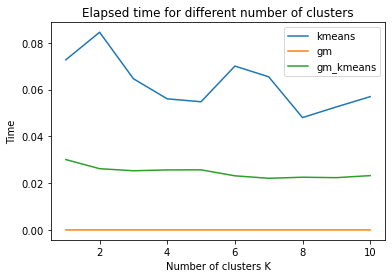

In [14]:
# Plotting the results from the dictionary
plt.plot(elapsed_time["k"], elapsed_time["kmeans"], label="kmeans")
plt.plot(elapsed_time["k"], elapsed_time["gm"], label="gm")
plt.plot(elapsed_time["k"], elapsed_time["gm_kmeans"], label="gm_kmeans")
plt.legend()
plt.title("Elapsed time for different number of clusters")
plt.xlabel("Number of clusters K")
plt.ylabel("Time")
plt.show()


It is quite strange that a plain K-Means is slower than GM with a K-Means initializer. Behind the hood, Scikit-Learn seems to apply an optimized version of K-Means that takes fewer iterations to converge.

Also, vanilla GM takes a very short amount of time. This happens because it finds a local minimum quite fast which is not even close to the global minimum.

## So Which Algorithm Should I Choose?

If you look for robustness, GM with K-Means initializer seems to be the best option. K-Means should be theoretically faster if you experiment with different parameters, but as we can see from the computation plot above, GM with K-Means initializer is the fastest. GM on its own is not much of use because it converges too fast to a non-optimal solution for this dataset.